# Détection d'anomalies : Mickey Mouse

In [1]:
import numpy as np
from sklearn.ensemble import IsolationForest
np.set_printoptions(threshold=10000, suppress = True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


In [2]:
def d_confusion_matrix(data, anomalies, outliers):
    negat = data.merge(anomalies, how='left', indicator=True)
    negat = negat[negat['_merge'] == 'left_only'].drop(columns=['_merge'])
    FN = 0
    TP = 0
    for i in np.array(anomalies): 
        if i in np.array(outliers):
            TP = TP + 1
    FP = len(anomalies)-TP
    for i in np.array(negat):
        if i in np.array(outliers):
            FN = FN + 1
    TN = len(negat)-FN
    return [[TP, FP], [FN, TN]]

def f1_sc(matrix):
    TP = matrix[0][0]
    FP = matrix[0][0]
    FN = matrix[1][0]
    return TP/(TP+0.5*(FN+FP))

In [3]:
data = pd.read_csv('data/mouse.txt', delimiter=" ", header=None, names=['x', 'y'])
outliers = data.tail(10)

### Visualiser les données :

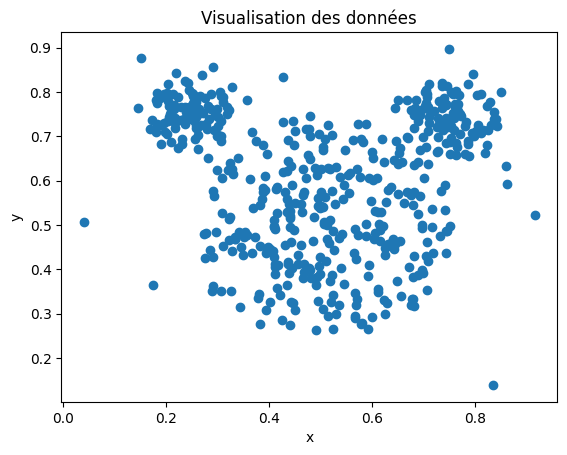

In [4]:
plt.scatter(data['x'], data['y'])
plt.title("Visualisation des données")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Isolation Forest

Nous connaissons le nombre d'anomalies dans le dataset, donc nous pouvons choisir un taux de contamination de $\frac{10}{500} = 0.02$

In [5]:
conta_rate = 10/len(data)
model = IsolationForest(contamination=conta_rate)
model.fit(data)
scores = model.decision_function(data)

anomalies_isf = data[scores < 0]

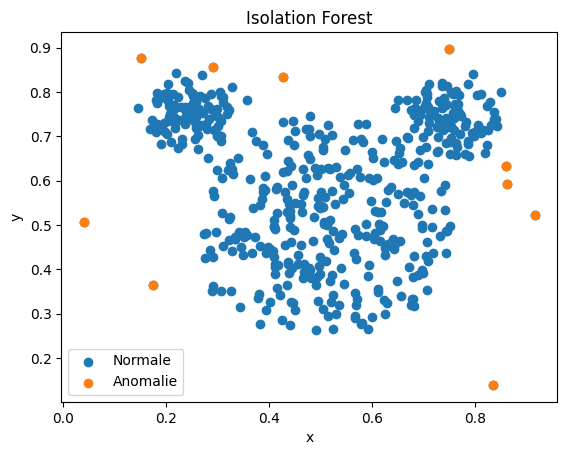

In [6]:
plt.scatter(data['x'], data['y'], label='Normale')
plt.scatter(anomalies_isf['x'], anomalies_isf['y'], label="Anomalie")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Isolation Forest")
plt.legend()
plt.show()

La matrice de confusion ci-dessous est de la forme :  $[[TP, FP], [FN, TN]]$

In [7]:
confusion_matrix = d_confusion_matrix(data,anomalies_isf, outliers)
print(confusion_matrix)

[[10, 0], [0, 490]]


In [8]:
print("Soit un F1-score de : ", f1_sc(confusion_matrix))

Soit un F1-score de :  0.6666666666666666


### Outlier Factor

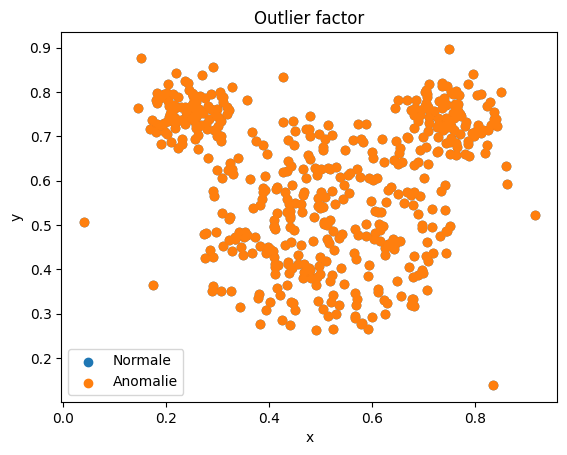

In [9]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor


model = LocalOutlierFactor(n_neighbors=7, contamination=conta_rate)
model.fit(data)

threshold = pd.Series(scores).quantile(1-conta_rate)
scores = -model.negative_outlier_factor_
anomalies_olf = data[scores > threshold]

plt.scatter(data['x'], data['y'], label='Normale')
plt.scatter(anomalies_olf['x'], anomalies_olf['y'], label="Anomalie")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Outlier factor")
plt.show()

La matrice de confusion ci-dessous est de la forme :  $[[TP, FP], [FN, TN]]$

In [10]:
matrix = d_confusion_matrix(data,anomalies_olf,outliers)
print(matrix)

[[10, 490], [0, 0]]


In [11]:
print("soit un F1-score de : ",f1_sc(matrix))

soit un F1-score de :  0.6666666666666666


### Comparaison

In [12]:
common= pd.merge(anomalies_olf, anomalies_isf, how='inner')

anomalies_olf_wo_common = anomalies_olf.merge(common, on=['x', 'y'], how='left', indicator=True)
anomalies_olf_wo_common = anomalies_olf_wo_common[anomalies_olf_wo_common['_merge'] == 'left_only'].drop(columns=['_merge'])

anomalies_isf_wo_common = anomalies_isf.merge(common, on=['x', 'y'], how='left', indicator=True)
anomalies_isf_wo_common = anomalies_isf_wo_common[anomalies_isf_wo_common['_merge'] == 'left_only'].drop(columns=['_merge'])

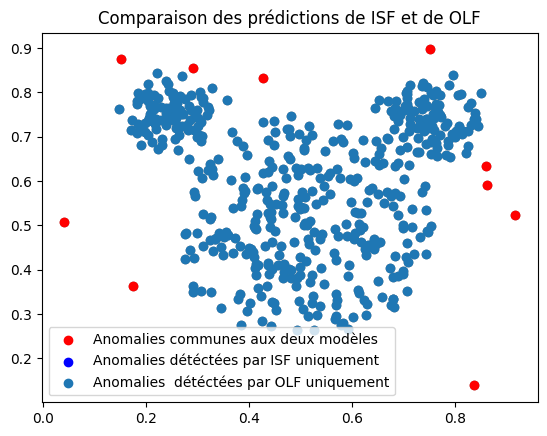

In [13]:
plt.scatter(data['x'], data['y'], color='grey')
plt.scatter(common['x'], common['y'], color='red', label='Anomalies communes aux deux modèles')
plt.scatter(anomalies_isf_wo_common['x'], anomalies_isf_wo_common['y'], color='blue',label='Anomalies détéctées par ISF uniquement')
plt.scatter(anomalies_olf_wo_common['x'], anomalies_olf_wo_common['y'], label = 'Anomalies  détéctées par OLF uniquement')
plt.title("Comparaison des prédictions de ISF et de OLF")
plt.legend()
plt.show()

Par MOREAU Maxime